## Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('D:\data_proj/forFBpost.csv', sep=';')
df

,Город,year,fact,Модель,Нижняя граница,Верхняя граница
0,Белокуриха,2000,NaN,15400.0,15100.0,15700.0
1,Белокуриха,2001,NaN,15400.0,15100.0,15700.0
2,Белокуриха,2002,NaN,15400.0,15000.0,15700.0
3,Белокуриха,2003,NaN,15300.0,15000.0,15700.0
4,Белокуриха,2004,NaN,15300.0,14900.0,15600.0
...,...,...,...,...,...,...
30245,Облучье,2116,NaN,300.0,100.0,800.0
30246,Облучье,2117,NaN,300.0,100.0,800.0
30247,Облучье,2118,NaN,300.0,100.0,800.0
30248,Облучье,2119,NaN,300.0,100.0,800.0


Для удобства дальнейшей работы переименуем столбцы и приведем их к нижнему регистру.

In [3]:
df.columns = ['city', 'year', 'fact', 'model', 'bottom_line', 'upper_line']

Изучим датасет на наличие пропусков и дубликатов:

In [4]:
df.info()
print(df.isna().mean())
print('Всего дубликатов:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30250 entries, 0 to 30249
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         30250 non-null  object 
 1   year         30250 non-null  int64  
 2   fact         3250 non-null   float64
 3   model        30250 non-null  float64
 4   bottom_line  30250 non-null  float64
 5   upper_line   30250 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
city           0.000000
year           0.000000
fact           0.892562
model          0.000000
bottom_line    0.000000
upper_line     0.000000
dtype: float64
Всего дубликатов: 0


Дубликатов нет, но в столбце fact пропусков почти 90%. Полагаю, это может быть связано с тем, что в какие-то года перепись населения не производилась, или пропуски присутствуют в еще не наступивших годах. Изучим стобец year:


In [5]:
df['year'].describe()

count    30250.000000
mean      2060.000000
std         34.929076
min       2000.000000
25%       2030.000000
50%       2060.000000
75%       2090.000000
max       2120.000000
Name: year, dtype: float64

Действительно, в исходном датасете представлены предсказания для численности населения до 2120 года, потому обилие пропусков объяснимо.

В столбцах fact, model, bottom_line и upper_line данные представлены типом float. С целью экономии представим их в формате integer:

In [6]:
df = df.convert_dtypes()

Убедимся, что преобразование типов произошло корректно

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30250 entries, 0 to 30249
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         30250 non-null  string
 1   year         30250 non-null  Int64 
 2   fact         3250 non-null   Int64 
 3   model        30250 non-null  Int64 
 4   bottom_line  30250 non-null  Int64 
 5   upper_line   30250 non-null  Int64 
dtypes: Int64(5), string(1)
memory usage: 1.5 MB


Приступим к исследовательскому анализу данных!

## Исследовательскиц анализ данных

Посмотрим на графики с действительными значениями и прогнозами для городов для нескольких городов:

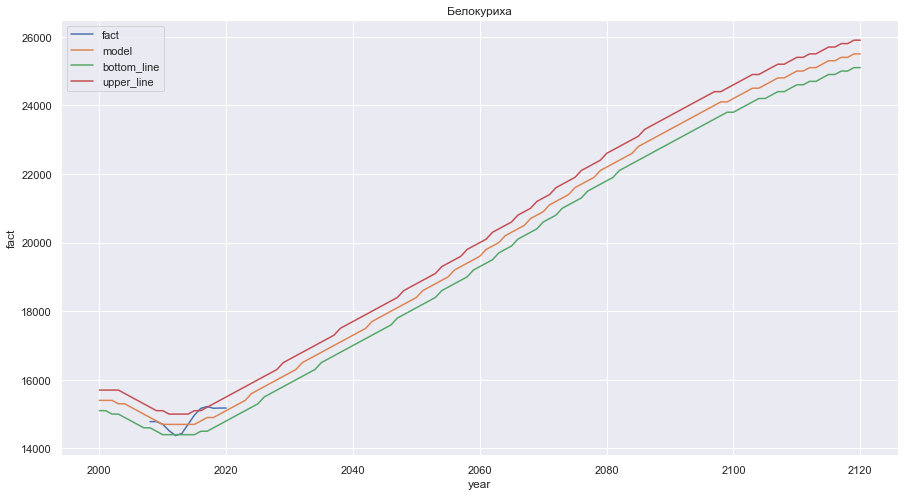

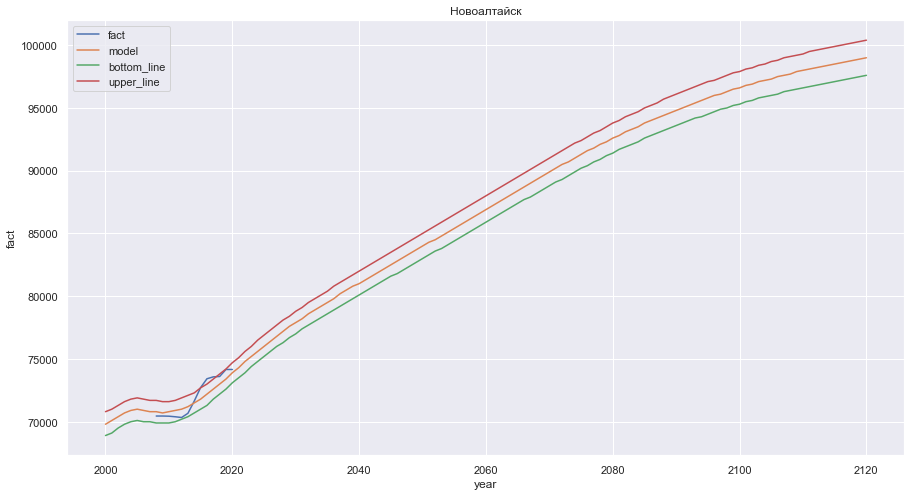

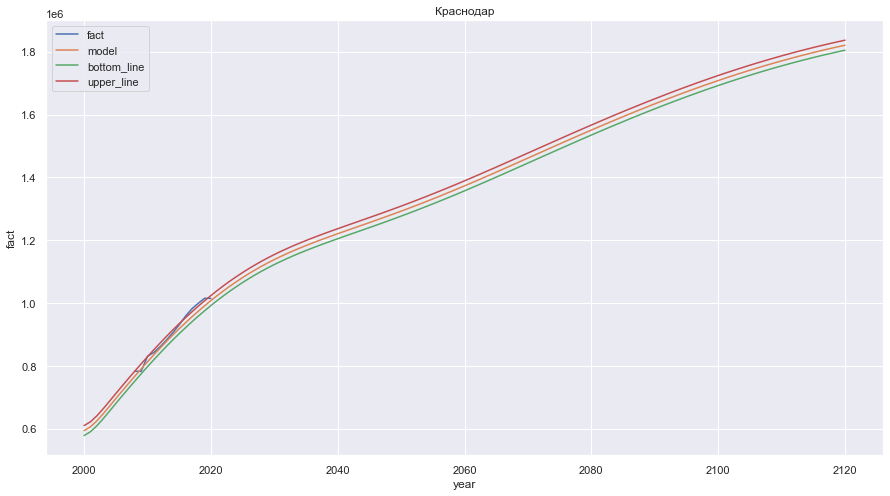

In [8]:
for city in ['Белокуриха', 'Новоалтайск', 'Краснодар']:
    plt.figure(figsize=(15,8))
    sns.set_theme(style="darkgrid")
    for lab in ['fact', 'model', 'bottom_line', 'upper_line']:
        ax = sns.lineplot(x=df[df['city']==city].year, y=df[df['city']==city][lab], label=lab, legend='full')
    ax.set_title(f'{city}')
    plt.show()
  

Посмотрим, фактическое население в 2020 году и ожидаемое в 2021 для каждого городая:

In [9]:
df_first = pd.DataFrame({'city':'Белокуриха',
                       '2020': df[(df['city']=='Белокуриха') & (df['year']==2020)].fact})
df_second = pd.DataFrame({'city':'Белокуриха',
                       '2120': df[(df['city']=='Белокуриха') & (df['year']==2120)].model})
for city in df['city'].unique():
    if city !='Белокуриха':
        first_append = pd.DataFrame({'city':city,
                       '2020': df[(df['city']==city) & (df['year']==2020)].fact})
        df_first = pd.concat([df_first, first_append])
    
        second_append = pd.DataFrame({'city':city,
                       '2120': df[(df['city']==city) & (df['year']==2120)].model})
        df_second = pd.concat([df_second, second_append])

In [10]:
df_new = df_first.merge(df_second, on='city')
df_new

,city,2020,2120
0,Белокуриха,15176,25500
1,Новоалтайск,74163,99000
2,Краснодар,1014996,1820700
3,Анапа,199851,734900
4,Бородино,16058,13800
...,...,...,...
249,Алатырь,33394,34500
250,Новочебоксарск,127706,216200
251,Мирный,35403,69400
252,Якутск,343423,1197300


Посмотрим, в скольких городах население сократится, а в скольких увеличится:

In [11]:
population_up = 0
for i in range(len(df_new)):
    if (df_new['2120'].iloc[i] - df_new['2020'].iloc[i]) >=0:
        population_up +=1
        
print(f'Население увеличится в {population_up} городах из {len(df_new)}')
print(f'Следовательно, уменьшится в {len(df_new)-population_up}')

Население увеличится в 94 городах из 254
Следовательно, уменьшится в 160


Посмотрим на общую картину и сравним фактическое население в 2020 году и ожидаемое в 2120:

In [12]:
total_2020 = df_new['2020'].sum()
total_2120 = df_new['2120'].sum()
print(f'Суммарное фактическое население в 2020 году составило {total_2020} человек, ожидаемое в 2120 году - {total_2120} человек.') 
print(f'Таким образом, ожидается увеличение численности населения в {total_2120/total_2020:.2f} раз')

Суммарное фактическое население в 2020 году составило 32789991 человек, ожидаемое в 2120 году - 40555400 человек.
Таким образом, ожидается увеличение численности населения в 1.24 раз


Несмотря на то, что в большинстве из рассматриваемых населеных пунктов ожидается уменьшение численности населения, общая численность увеличится. Предполагаю, в большинстве случаев сокращение населения ожидается в маленьких городах, поскольку в поисках лучшей жизни и больших возможностей люди уезжают в крупные города. Разделим населенные пункты на группы, которые будут указывать на темп изменения численности населения в каждом городе:

In [13]:
pd.options.mode.chained_assignment = None
df_new['change'] = 'default'
for i in range(len(df_new)):
    if (df_new['2120'].iloc[i] >= 2*df_new['2020'].iloc[i]):
        df_new['change'][i] = 'сильно увеличилось'
    elif (df_new['2120'].iloc[i] >= 1.2*df_new['2020'].iloc[i]) & (df_new['2120'].iloc[i] < 2*df_new['2020'].iloc[i]):
        df_new['change'][i] = 'увеличилось'
    elif (df_new['2120'].iloc[i] >= 0.8*df_new['2020'].iloc[i]) & (df_new['2120'].iloc[i] < 1.2*df_new['2020'].iloc[i]):
        df_new['change'][i] = 'небольшие изменения'
    elif (df_new['2120'].iloc[i] >= 0.5*df_new['2020'].iloc[i]) & (df_new['2120'].iloc[i] < 0.8*df_new['2020'].iloc[i]):
        df_new['change'][i] = 'уменьшилось'
    elif (df_new['2120'].iloc[i] < 0.5*df_new['2020'].iloc[i]):
        df_new['change'][i] = 'сильно уменьшилось'

df_new

,city,2020,2120,change
0,Белокуриха,15176,25500,увеличилось
1,Новоалтайск,74163,99000,увеличилось
2,Краснодар,1014996,1820700,увеличилось
3,Анапа,199851,734900,сильно увеличилось
4,Бородино,16058,13800,небольшие изменения
...,...,...,...,...
249,Алатырь,33394,34500,небольшие изменения
250,Новочебоксарск,127706,216200,увеличилось
251,Мирный,35403,69400,увеличилось
252,Якутск,343423,1197300,сильно увеличилось


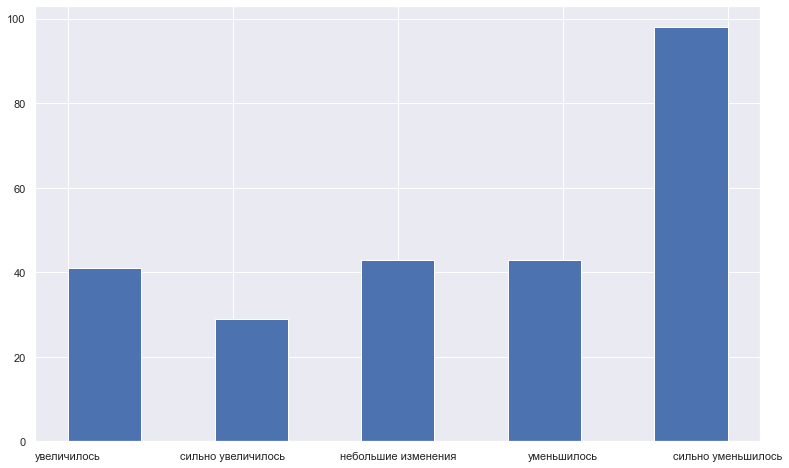

In [14]:
plt.figure(figsize=(13,8))
plt.hist(df_new['change'], bins=9)
plt.show()

Теперь посторим на мединное и среднее значение численности населения в 2020 году для каждой категории:

In [15]:
for chan in df_new['change'].unique():
    mean = format(df_new[df_new['change'] == chan]['2020'].mean(), '.0f') #уберем дробную часть
    median = format(df_new[df_new['change'] == chan]['2020'].median(), '.0f')
    print(f'для категории "{chan}" среднее - {mean}, медиана - {median}')

для категории "увеличилось" среднее - 402329, медиана - 35403
для категории "сильно увеличилось" среднее - 69198, медиана - 41403
для категории "небольшие изменения" среднее - 84507, медиана - 29783
для категории "уменьшилось" среднее - 135738, медиана - 38452
для категории "сильно уменьшилось" среднее - 49155, медиана - 23901


Полученные результаты получились малоинформативными. Попробуем другой подход: поделим на категории сами города в соответствиями с типами поселений Российской Федерации:

In [16]:
def city_type(data, new_type, year):
    data[new_type]='default'
    for i in range(len(data)):
        if (data[year].iloc[i] >= 1000000):
            data[new_type][i] = 'крупнейший'
        elif (data[year].iloc[i] < 1000000) & (data[year].iloc[i] >= 250000):
            data[new_type][i] = 'крупный'
        elif (data[year].iloc[i] < 250000) & (data[year].iloc[i] >= 100000):
            data[new_type][i] = 'большой'
        elif (data[year].iloc[i] < 100000) & (data[year].iloc[i] >= 50000):
            data[new_type][i] = 'средний'
        elif (df_new[year].iloc[i] < 50000):
            data[new_type][i] = 'малый'


Применим эту функцию дважды: для фактических и прогнозируемых значений:


In [17]:
city_type(df_new, 'type_2020', '2020')
city_type(df_new, 'type_2120', '2120')
df_new

,city,2020,2120,change,type_2020,type_2120
0,Белокуриха,15176,25500,увеличилось,малый,малый
1,Новоалтайск,74163,99000,увеличилось,средний,средний
2,Краснодар,1014996,1820700,увеличилось,крупнейший,крупнейший
3,Анапа,199851,734900,сильно увеличилось,большой,крупный
4,Бородино,16058,13800,небольшие изменения,малый,малый
...,...,...,...,...,...,...
249,Алатырь,33394,34500,небольшие изменения,малый,малый
250,Новочебоксарск,127706,216200,увеличилось,большой,большой
251,Мирный,35403,69400,увеличилось,малый,средний
252,Якутск,343423,1197300,сильно увеличилось,крупный,крупнейший


Теперь посмотрим на количество городов каждого типа в 2020 и 2120 годах:

In [18]:
df_new['type_2020'].value_counts()

малый         165
средний        37
большой        35
крупный        14
крупнейший      3
Name: type_2020, dtype: int64

In [19]:
df_new['type_2120'].value_counts()

малый         173
средний        32
большой        28
крупный        15
крупнейший      6
Name: type_2120, dtype: int64

Для наглядности посмотрим сравнительную диаграму:

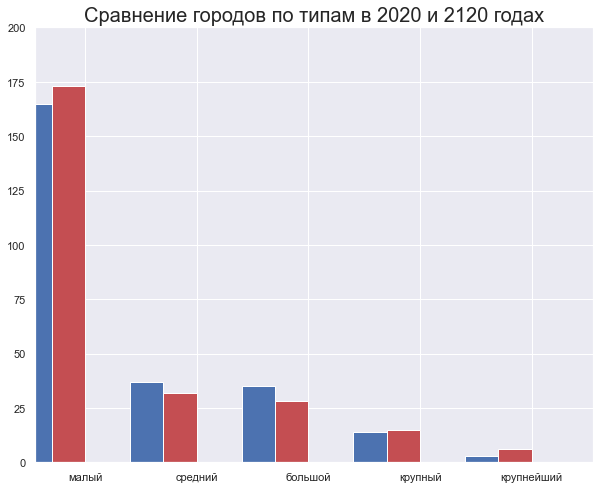

In [20]:
fig = plt.figure(figsize=(10,8))
index = np.arange(len(df_new['type_2020'].unique()))
values1 = df_new['type_2020'].value_counts()
values2 = df_new['type_2120'].value_counts()

bw = 0.3
plt.axis([0,5,0,200])
plt.title('Сравнение городов по типам в 2020 и 2120 годах', fontsize=20)
plt.bar(index, values1, bw, color='b', label='2020')
plt.bar(index+bw, values2, bw, color='r', label='2021')

plt.xticks(index+1.5*bw,['малый','средний','большой','крупный','крупнейший'])
plt.show()


Как можно заметить, к 2120 незначительно увеличится количество малых городов и уменьшится количество средних и больших (до 20%). Количество крупных городов останется практически таким же, а вот "миллионников" станет в 2 раза больше.

## Вывод

- К 2120 ожидается общее увеличение численности населения в указанных городах в 1.24 раза (на 24%);
- Лишь в 90 городах численность населения увеличится, когда в 164 сократится. Притом больше всего таких населенных пунктов, где ожидается убыль населения более, чем в 2 раза;
- К 2120 году ожидается двукратное увеличение крупнейших городов, когда изменения количества городов в других категориях составит не более 20%.